In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets 
import torchvision.transforms as transforms

In [2]:
input_size = 784        #Number of input neurons (image pixels, 28x28)
hidden_size0 = 128
hidden_size1 = 64       #Number of hidden neurons
out_size = 10           #Number of classes (0-9) 
epochs = 10            #How many times we pass our entire dataset into our network 
batch_size = 64        #Input size of the data during one iteration 
learning_rate = 0.001   #How fast we are learning

In [3]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

![nn mnist](https://user-images.githubusercontent.com/30661597/61593615-5eb8bf00-ac14-11e9-8087-f880971b3543.png)


In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size0)     #784 - 128
        self.fc2 = nn.Linear(hidden_size0, hidden_size1)   #128 - 64
        self.fc3 = nn.Linear(hidden_size1, out_size)       #64 - 1
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [6]:
#Create an object of the class, which represents our network 
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()
#The loss function. The Cross Entropy loss comes along with Softmax. Therefore, no need to specify Softmax as well
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [7]:
print(CUDA)

True


In [8]:
#Training
for epoch in range(epochs):
    correct_train = 0
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):   
        #(batch,1,28,28)
        images = images.view(-1, 28*28)    
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
            
        outputs = net(images)       
        _, predicted = torch.max(outputs.data, 1)                                              
        correct_train += (predicted == labels).sum() 
        loss = criterion(outputs, labels)                 
        running_loss += loss.item()
        optimizer.zero_grad() 
        loss.backward()                                   
        optimizer.step()                                  
        
    print('Epoch [{}/{}], Training Loss: {:.3f}, Training Accuracy: {:.3f}%'.format
          (epoch+1, epochs, running_loss/len(train_loader), (100*correct_train.double()/len(train_dataset))))
print("DONE TRAINING!")

Epoch [1/10], Training Loss: 0.262, Training Accuracy: 92.328%
Epoch [2/10], Training Loss: 0.110, Training Accuracy: 96.648%
Epoch [3/10], Training Loss: 0.073, Training Accuracy: 97.752%
Epoch [4/10], Training Loss: 0.056, Training Accuracy: 98.207%
Epoch [5/10], Training Loss: 0.044, Training Accuracy: 98.590%
Epoch [6/10], Training Loss: 0.035, Training Accuracy: 98.802%
Epoch [7/10], Training Loss: 0.027, Training Accuracy: 99.117%
Epoch [8/10], Training Loss: 0.024, Training Accuracy: 99.215%
Epoch [9/10], Training Loss: 0.022, Training Accuracy: 99.260%
Epoch [10/10], Training Loss: 0.020, Training Accuracy: 99.335%
DONE TRAINING!


In [10]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.ndimage import gaussian_filter

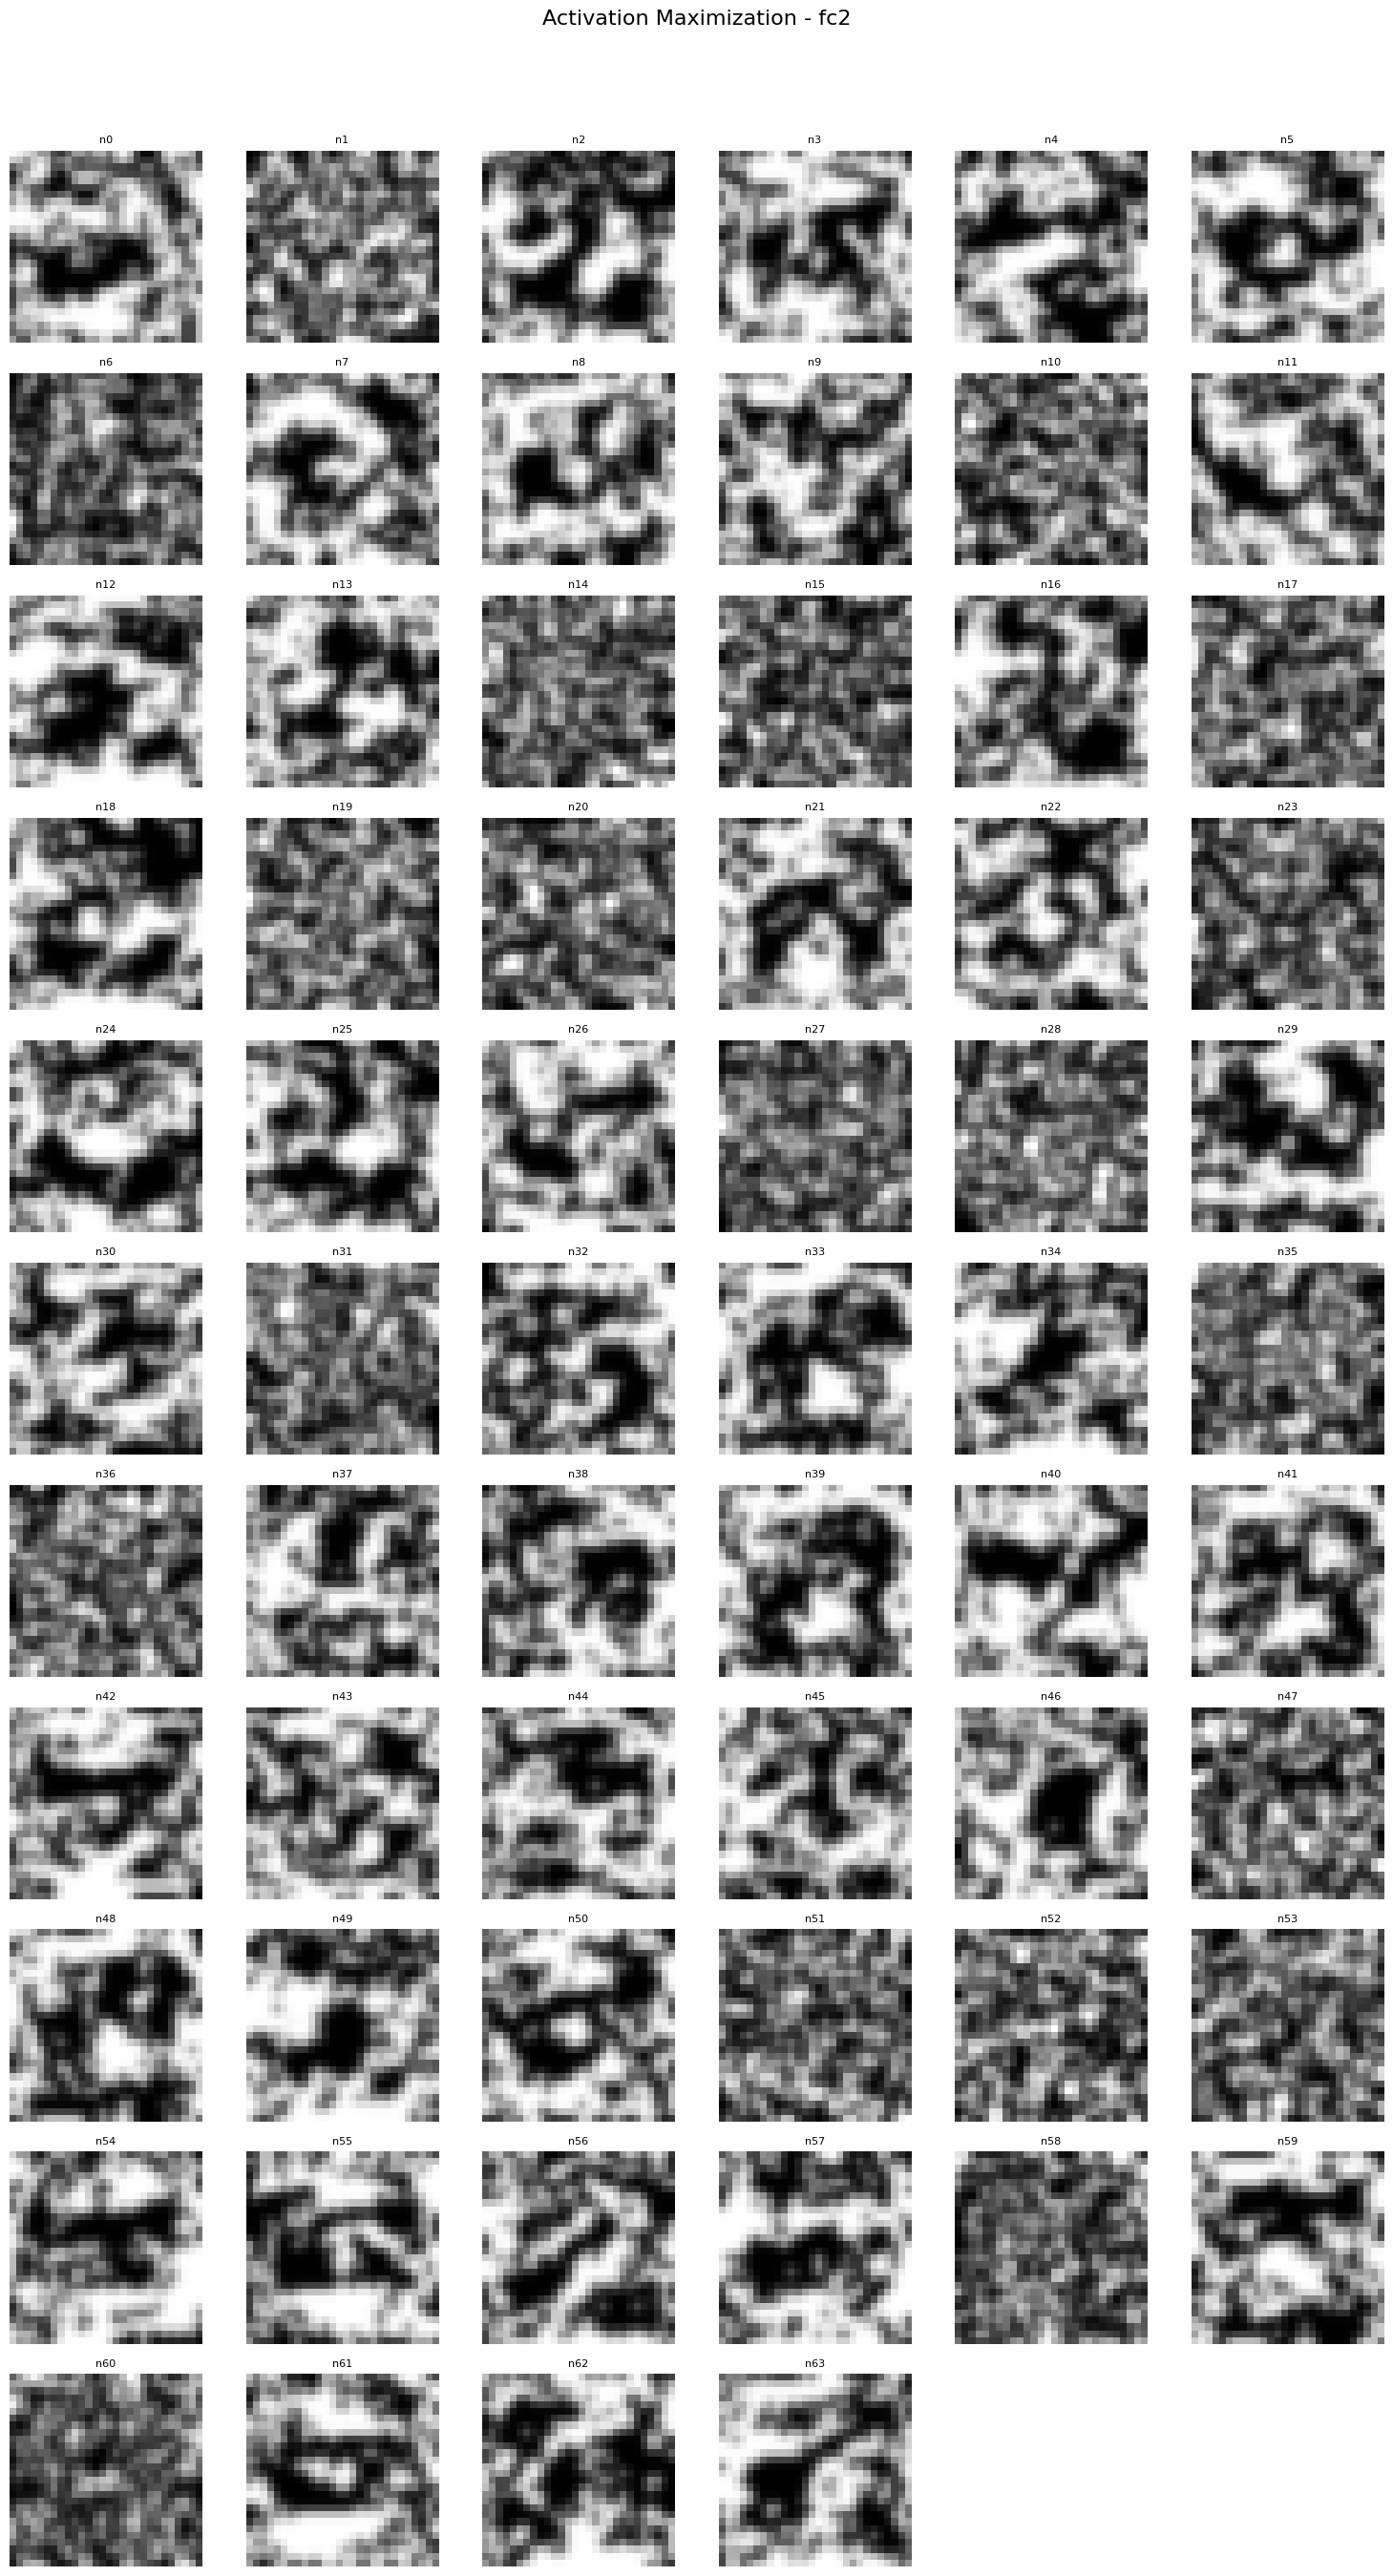

In [11]:
layer_name = "fc2"
neuron_indices = []
for i in range(64):
    neuron_indices.append(i)
steps = 200
lr = 0.1
smoothing_sigma = 0.8

def get_activation(net, x, layer, neuron_idx):
    out1 = F.relu(net.fc1(x))
    out2 = F.relu(net.fc2(out1))
    out3 = F.relu(net.fc3(out2))
    if layer == "fc1":
        return out1[0, neuron_idx]
    elif layer == "fc2":
        return out2[0, neuron_idx]
    elif layer == "fc3":
        return out3[0, neuron_idx]
    else:
        raise ValueError("Invalid layer")

net.eval()
device = 'cuda' if CUDA else 'cpu'
images = []

for idx in neuron_indices:
    input_image = torch.randn(1, 784, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([input_image], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()
        activation = get_activation(net, input_image, layer_name, idx)
        loss = -activation
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            input_image.clamp_(0, 1)

    img_np = input_image.detach().cpu().view(28, 28).numpy()
    if smoothing_sigma > 0:
        img_np = gaussian_filter(img_np, sigma=smoothing_sigma) #to make smoother
    images.append(img_np)

#plotting
cols=6
img_size=28
n = len(images)
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 2.5, rows * 2.5))

for i, img in enumerate(images):
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'n{neuron_indices[i]}', fontsize=8)
    ax.axis('off')

plt.suptitle(f'Activation Maximization - {layer_name}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

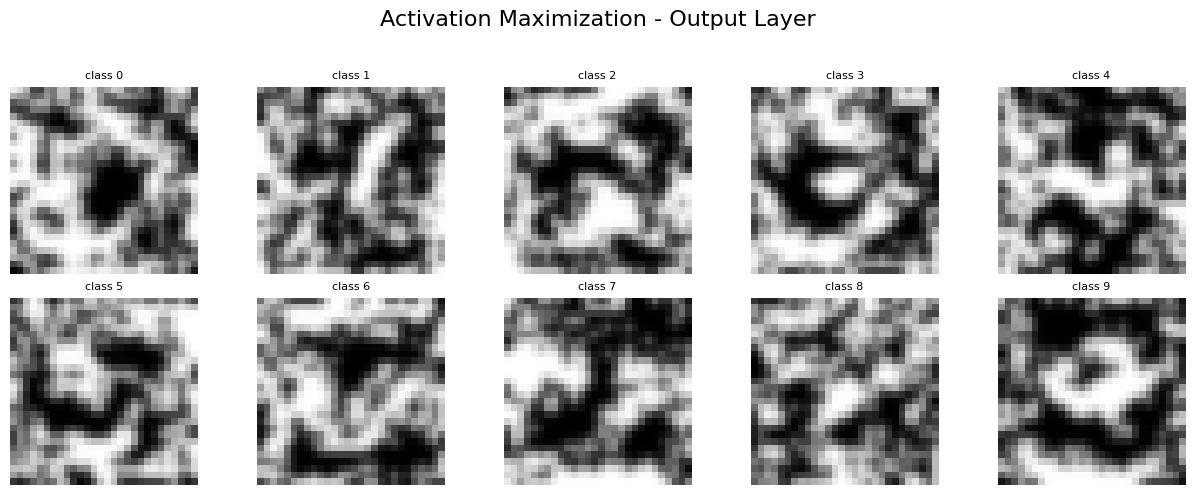

In [12]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.ndimage import gaussian_filter


layer_name = "output"
neuron_indices = list(range(10))
steps = 200
lr = 0.1
smoothing_sigma = 0.8

net.eval()
device = 'cuda' if CUDA else 'cpu'
images = []

for idx in neuron_indices:
    input_image = torch.randn(1, 784, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([input_image], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()
        logits = net(input_image)
        activation = logits[0, idx]
        loss = -activation
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            input_image.clamp_(0, 1)

    img_np = input_image.detach().cpu().view(28, 28).numpy()
    if smoothing_sigma > 0:
        img_np = gaussian_filter(img_np, sigma=smoothing_sigma)
    images.append(img_np)

#plotting
cols = 5
img_size = 28
n = len(images)
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 2.5, rows * 2.5))
for i, img in enumerate(images):
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'class {neuron_indices[i]}', fontsize=8)
    ax.axis('off')

plt.suptitle(f'Activation Maximization - Output Layer', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [13]:
with torch.no_grad():
    correct = 0
    for images, labels in test_loader:
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / len(test_dataset)))

Accuracy of the network on the 10000 test images: 97.43 %
